<a href="https://colab.research.google.com/github/tejaspradhan/Face-Generation-from-Textual-Features-using-GANs/blob/main/Pytorch_Text2Face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


# StyleGAN

In [ ]:
!git clone https://github.com/NVlabs/stylegan2.git

fatal: destination path 'stylegan2' already exists and is not an empty directory.


In [ ]:
%cd stylegan2/
!ls

/content/stylegan2
dataset_tool.py  LICENSE.txt		 __pycache__	   run_projector.py
dnnlib		 metrics		 README.md	   run_training.py
Dockerfile	 pretrained_networks.py  run_generator.py  test_nvcc.cu
docs		 projector.py		 run_metrics.py    training


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
import pickle

import pretrained_networks
from dnnlib import tflib as tflib
import numpy as np
import PIL.Image
import dnnlib
from matplotlib.pyplot import imshow
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPool1D, Dense, Flatten
%matplotlib inline

In [ ]:
# loading pretrained network
G, D, Gs = pretrained_networks.load_networks('/content/drive/MyDrive/Text2Face/Models/stylegan2-ffhq-config-f.pkl')

noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]
truncation_psi=1.0
Gs_kwargs = dnnlib.EasyDict()
Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
Gs_kwargs.randomize_noise = False
if truncation_psi is not None:
    Gs_kwargs.truncation_psi = truncation_psi

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.


In [ ]:
seed =4000
print('Generating image for seed %d...' % (seed))
rnd = np.random.RandomState(seed)
z = rnd.randn(1, *Gs.input_shape[1:])
print("Noise Vars: ",noise_vars)
print("Input size: ",*Gs.input_shape[1:])
tflib.set_vars({var: rnd.randn(*var.shape.as_list()) for var in noise_vars}) 
images = Gs.run(z, None, **Gs_kwargs)
img=PIL.Image.fromarray(images[0], 'RGB')
imshow(img)

Generating image for seed 4000...
Noise Vars:  [<tf.Variable 'G_synthesis_1/noise0:0' shape=(1, 1, 4, 4) dtype=float32_ref>, <tf.Variable 'G_synthesis_1/noise1:0' shape=(1, 1, 8, 8) dtype=float32_ref>, <tf.Variable 'G_synthesis_1/noise2:0' shape=(1, 1, 8, 8) dtype=float32_ref>, <tf.Variable 'G_synthesis_1/noise3:0' shape=(1, 1, 16, 16) dtype=float32_ref>, <tf.Variable 'G_synthesis_1/noise4:0' shape=(1, 1, 16, 16) dtype=float32_ref>, <tf.Variable 'G_synthesis_1/noise5:0' shape=(1, 1, 32, 32) dtype=float32_ref>, <tf.Variable 'G_synthesis_1/noise6:0' shape=(1, 1, 32, 32) dtype=float32_ref>, <tf.Variable 'G_synthesis_1/noise7:0' shape=(1, 1, 64, 64) dtype=float32_ref>, <tf.Variable 'G_synthesis_1/noise8:0' shape=(1, 1, 64, 64) dtype=float32_ref>, <tf.Variable 'G_synthesis_1/noise9:0' shape=(1, 1, 128, 128) dtype=float32_ref>, <tf.Variable 'G_synthesis_1/noise10:0' shape=(1, 1, 128, 128) dtype=float32_ref>, <tf.Variable 'G_synthesis_1/noise11:0' shape=(1, 1, 256, 256) dtype=float32_ref>, <t

In [ ]:
img.size

(1024, 1024)

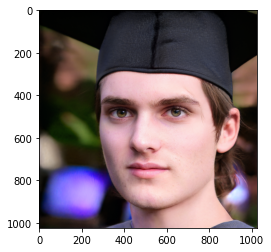

In [ ]:
imshow(img)

## Custom Methods

In [ ]:
def stylegan_generate_image(latent_vector):
  seed = np.random.randint(10000)
  #print('Generating image for seed %d...' % (seed))
  rnd = np.random.RandomState(seed)
  z = np.array([latent_vector])
  #print("Noise Vars: ",noise_vars)
  #print("Input size: ",*Gs.input_shape[1:])
  # print("Input: \n",latent_vector)
  tflib.set_vars({var: rnd.randn(*var.shape.as_list()) for var in noise_vars}) 
  images = Gs.run(z, None, **Gs_kwargs)
  img=PIL.Image.fromarray(images[0], 'RGB')
  #return np.array(img)
  return img

In [ ]:
def resize_image(img, target_width=64):
  mywidth = target_width
  wpercent = mywidth/float(img.size[0])
  hsize = int((float(img.size[1])*float(wpercent)))
  img = img.resize((mywidth,hsize), PIL.Image.ANTIALIAS)
  return np.array(img)

## Loading Data

In [ ]:
embeddings = np.load('/content/drive/MyDrive/Text2Face/Dataset/embeddings/embeddings_37k.npz')['arr_0']

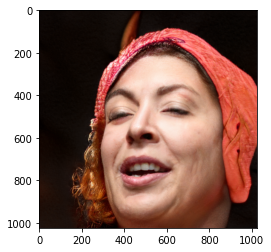

In [ ]:
img =stylegan_generate_image(embeddings[10])
imshow(img)

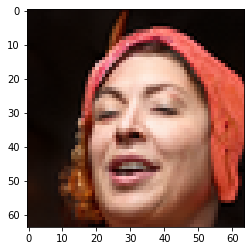

In [ ]:
imshow(resize_image(img))

In [ ]:
print(img.size)

(1024, 1024)


In [ ]:
face_data = pd.read_csv('/content/drive/MyDrive/Text2Face/Dataset/face_features_csv/face_features_preprocessed.csv')

In [ ]:
face_ids=face_data['image_id']

In [ ]:
face_ids = face_ids[:30000]

In [ ]:
face_ids.shape

(30000,)

In [ ]:
embeddings = embeddings[:30000]

In [ ]:
embeddings.shape

(30000, 512)

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Text2Face/Dataset/celebA/'+face_ids[0][:-4]+".png")
img=img[...,::-1]
print(img.shape)

(64, 64, 3)


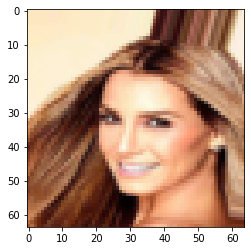

In [ ]:
imshow(img)

## Training 

In [ ]:
from PIL import Image

In [ ]:
BATCH_SIZE =32
NO_OF_BATCHES=BATCH_SIZE*4

In [ ]:
def get_images(face_ids, batch_size=32):
  num_batches = int(np.round(len(face_ids)/float(batch_size)))
  image_batches=[]
  for i in range(num_batches): 
    image_ids = face_ids[32*i:32*i+32]
    batch_images = []
    for id in image_ids: 
      img = cv2.imread('/content/drive/MyDrive/Text2Face/Dataset/celebA/'+id[:-4]+".png")
      img=img[...,::-1]
      batch_images.append(img)
    image_batches.append(batch_images)
    print("Batch Number: ", i,"Dataset Size: ",len(image_batches))
  return np.array(image_batches)

In [ ]:
batch_data = get_images(face_ids)

In [ ]:
np.save('/content/drive/MyDrive/Text2Face/Dataset/image_batch_data',batch_data)

In [ ]:
batch_data = np.load('/content/drive/MyDrive/Text2Face/Dataset/image_batch_data.npy',allow_pickle=True)

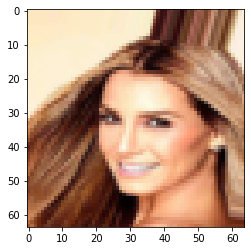

In [ ]:
imshow(np.array(batch_data)[0][0])

In [ ]:
def get_batch_embeddings(embeddings, batch_size=32):
  num_batches = int(np.round(len(embeddings)/float(batch_size)))
  emb_batches=[]
  for i in range(num_batches): 
    emb = embeddings[32*i:32*i+32] 
    emb_batches.append(emb)
    print("Batch Number: ", i,"Dataset Size: ",len(emb_batches))
  return np.array(emb_batches)

In [ ]:
embeddings_batches = get_batch_embeddings(embeddings)

In [ ]:
np.save('/content/drive/MyDrive/Text2Face/Dataset/embedding_batch_data',embeddings_batches)

In [ ]:
embeddings_batches = np.load('/content/drive/MyDrive/Text2Face/Dataset/embedding_batch_data.npy',allow_pickle =True)

## Experimenting with Pytorch

In [ ]:
import torch
from torch import nn

In [ ]:
# Trying out torch stuff
x1=torch.ones(2,2,3)
print("x1: ",x1)
x2=torch.zeros(2,2,3)
print("x2: ",x2)

x1:  tensor([[[1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.]]])
x2:  tensor([[[0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.]]])


In [ ]:
x2-x1

tensor([[[-1., -1., -1.],
         [-1., -1., -1.]],

        [[-1., -1., -1.],
         [-1., -1., -1.]]])

In [ ]:
torch.mean(x2-x1)

tensor(-1.)

## Defining Intermediate Trainable Model

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten(start_dim=512, end_dim=512)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
        )

    def forward(self, x):
        #x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
model = NeuralNetwork().to('cpu')
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=512, end_dim=512)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
  )
)


In [ ]:
print(model.children)

<bound method Module.children of NeuralNetwork(
  (flatten): Flatten(start_dim=512, end_dim=512)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
  )
)>


In [ ]:
def my_loss(output, target):
    output=resize_image(output,256)
    loss=np.mean(output-target)
    print(loss)
    loss = torch.tensor([loss],requires_grad=True,dtype=torch.float16)
    #loss=torch.tensor([10.5],requires_grad=True,dtype=torch.float16)
    return loss

In [ ]:
EPOCHS=5
NO_OF_INPUT=10

In [ ]:
images=get_images(face_ids[:NO_OF_INPUT])
images.shape

000001.jpg
000002.jpg
000003.jpg
000004.jpg
000005.jpg
000006.jpg
000007.jpg
000008.jpg
000009.jpg
000010.jpg


(10, 256, 256, 3)

In [ ]:
embeddings=embeddings[:NO_OF_INPUT]
embeddings.shape

(10, 512)

In [ ]:
#G
#model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for i in range(EPOCHS):
  print('Epoch: ',i)
  for image, embedding in zip(images,embeddings):
    optimizer.zero_grad()
    #print(embedding)
    ip=torch.Tensor(embedding)
    model_op=model(ip)
    
    model_op1=model_op.clone().detach().numpy()
    model_op1=model_op1.tolist()
    #print(model_op1)
    op_image=stylegan_generate_image(model_op1)
    imshow(op_image)
    loss=my_loss(op_image,image)
    loss.backward()
    optimizer.step()
  if i%2==0:
    print("Saving Model......")
    torch.save({
            'epoch': i,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, '/content/drive/MyDrive/Text2Face/Models/model--loss_'+str(loss.item())+'--epoch_'+str(i)+'.pt')

## Final Execution Cells


In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
!git clone https://github.com/NVlabs/stylegan2.git

fatal: destination path 'stylegan2' already exists and is not an empty directory.


In [3]:
%cd stylegan2/
!ls

/content/stylegan2
dataset_tool.py  LICENSE.txt		 __pycache__	   run_projector.py
dnnlib		 metrics		 README.md	   run_training.py
Dockerfile	 pretrained_networks.py  run_generator.py  test_nvcc.cu
docs		 projector.py		 run_metrics.py    training


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
import pickle

import pretrained_networks
from dnnlib import tflib as tflib
import numpy as np
import PIL.Image
import dnnlib
from matplotlib.pyplot import imshow
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPool1D, Dense, Flatten
import torch
from torch import nn
%matplotlib inline

In [34]:
# loading pretrained network
G, D, Gs = pretrained_networks.load_networks('/content/drive/MyDrive/Text2Face/Models/stylegan2-ffhq-config-f.pkl')

noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]
truncation_psi=1.0
Gs_kwargs = dnnlib.EasyDict()
Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
Gs_kwargs.randomize_noise = False
if truncation_psi is not None:
    Gs_kwargs.truncation_psi = truncation_psi

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Failed!


RuntimeError: ignored

In [8]:
def stylegan_generate_image(latent_vector):
  seed = np.random.randint(10000)
  #print('Generating image for seed %d...' % (seed))
  rnd = np.random.RandomState(seed)
  z = np.array([latent_vector])
  #print("Noise Vars: ",noise_vars)
  #print("Input size: ",*Gs.input_shape[1:])
  # print("Input: \n",latent_vector)
  tflib.set_vars({var: rnd.randn(*var.shape.as_list()) for var in noise_vars}) 
  images = Gs.run(z, None, **Gs_kwargs)
  img=PIL.Image.fromarray(images[0], 'RGB')
  #return np.array(img)
  return img

In [9]:
def resize_image(img, target_width=64):
  mywidth = target_width
  wpercent = mywidth/float(img.size[0])
  hsize = int((float(img.size[1])*float(wpercent)))
  img = img.resize((mywidth,hsize), PIL.Image.ANTIALIAS)
  return np.array(img)

In [23]:
# Get Batch Images
image_batches = np.load('/content/drive/MyDrive/Text2Face/Dataset/image_batch_data.npy',allow_pickle=True)

In [14]:
np.array(image_batches[0]).shape

(32, 64, 64, 3)

In [15]:
# Get Batch Embeddings
embeddings_batches = np.load('/content/drive/MyDrive/Text2Face/Dataset/embedding_batch_data.npy',allow_pickle =True)

In [17]:
np.array(embeddings_batches[0]).shape

(32, 512)

In [27]:
# Model Definition
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten(start_dim=512, end_dim=512)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
        )

    def forward(self, x):
        #x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [28]:
model = NeuralNetwork().to('cpu')
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=512, end_dim=512)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=512, bias=True)
  )
)


In [58]:
def my_loss(output, target):
    output=resize_image(output)
    loss=np.mean(output-target)
    loss = torch.tensor([loss],requires_grad=True,dtype=torch.float16)
    #loss=torch.tensor([10.5],requires_grad=True,dtype=torch.float16)
    return loss

In [59]:
EPOCHS = 3

In [60]:
def train_batch(image_batch, embedding_batch):
  batch_loss = 0
  for i in range(len(image_batch)):
    ip=torch.Tensor(embedding_batch[i])
    model_op=model(ip)
    model_op1=model_op.clone().detach().numpy()
    model_op1=model_op1.tolist()
    op_image=stylegan_generate_image(model_op1)
    batch_loss += my_loss(op_image,image_batch[i])
  return batch_loss/len(image_batch)

In [ ]:
#Train Model

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epoch_loss = []
for i in range(EPOCHS):
  print('Epoch: ',i)
  batch_loss = []
  batch_count = 0
  for image_batch, embedding_batch in zip(image_batches,embeddings_batches):
    print("Batch Number:", batch_count)
    image_batch = np.array(image_batch)
    embedding_batch = np.array(embedding_batch)
    optimizer.zero_grad()
    loss = train_batch(image_batch, embedding_batch)
    batch_loss.append(loss)
    print("Loss:", loss)
    loss.backward()
    optimizer.step()
    batch_count += 1
  
  epoch_loss.append(batch_loss)
  # Save Model after n epochs
  if i%2==0:
    print("Saving Model......")
    torch.save({
            'epoch': i,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, '/content/drive/MyDrive/Text2Face/Models/model--loss_'+str(loss.item())+'--epoch_'+str(i)+'.pt')

Epoch:  0
Batch Number: 0
Loss: tensor([127.3750], dtype=torch.float16, grad_fn=<DivBackward0>)
Batch Number: 1
Loss: tensor([126.5000], dtype=torch.float16, grad_fn=<DivBackward0>)
Batch Number: 2
Loss: tensor([123.], dtype=torch.float16, grad_fn=<DivBackward0>)
Batch Number: 3
Loss: tensor([125.4375], dtype=torch.float16, grad_fn=<DivBackward0>)
Batch Number: 4
Loss: tensor([126.7500], dtype=torch.float16, grad_fn=<DivBackward0>)
Batch Number: 5
Loss: tensor([126.5000], dtype=torch.float16, grad_fn=<DivBackward0>)
Batch Number: 6
Loss: tensor([122.6875], dtype=torch.float16, grad_fn=<DivBackward0>)
Batch Number: 7
Loss: tensor([121.2500], dtype=torch.float16, grad_fn=<DivBackward0>)
Batch Number: 8
Loss: tensor([118.0625], dtype=torch.float16, grad_fn=<DivBackward0>)
Batch Number: 9
Loss: tensor([120.7500], dtype=torch.float16, grad_fn=<DivBackward0>)
Batch Number: 10
Loss: tensor([121.6250], dtype=torch.float16, grad_fn=<DivBackward0>)
Batch Number: 11
Loss: tensor([122.4375], dtype

In [2]:
!pip install sentence_transformers

     |████████████████████████████████| 78 kB 3.3 MB/s 
     |████████████████████████████████| 3.4 MB 11.5 MB/s 
     |████████████████████████████████| 6.8 MB 40.1 MB/s 
     |████████████████████████████████| 1.2 MB 56.1 MB/s 
     |████████████████████████████████| 67 kB 4.3 MB/s 
     |████████████████████████████████| 3.3 MB 35.5 MB/s 
     |████████████████████████████████| 596 kB 50.7 MB/s 
     |████████████████████████████████| 895 kB 53.6 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=120999 sha256=0a354a57fd3f2768e2a310f714a64ff501f2cbdb0c31efa76fb9dbfa1b193725
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [11]:
from sentence_transformers import SentenceTransformer, models
from torch import nn

word_embedding_model = models.Transformer('bert-base-uncased', max_seq_length=256)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
dense_model = models.Dense(in_features=pooling_model.get_sentence_embedding_dimension(), out_features=512, activation_function=nn.Tanh())

encoder_model = SentenceTransformer(modules=[word_embedding_model, pooling_model, dense_model])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
description = "The woman has high cheekbones. She has straight hair which is black in colour. She has big lips with arched eyebrows. The smiling, young woman has rosy cheeks and heavy makeup. She is wearing lipstick."

In [13]:
test_embedding = encoder_model.encode(description)

In [14]:
test_embedding.shape

(512,)

In [30]:
checkpoint_model = torch.load('/content/drive/MyDrive/Text2Face/Models/model--loss_116.9375--epoch_0.pt')

In [31]:
model.load_state_dict(checkpoint_model['model_state_dict'])

<All keys matched successfully>

In [33]:
stylegan_generate_image(model(torch.from_numpy(test_embedding)))

NameError: ignored